<img alt="Colaboratory logo" height="45px" src="https://colab.research.google.com/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px">

<h1>Welcome to Colaboratory!</h1>

Colaboratory is a free Jupyter notebook environment that requires no setup and runs entirely in the cloud.

With Colaboratory you can write and execute code, save and share your analyses, and access powerful computing resources, all for free from your browser.

## Running code

Code cells can be executed in sequence by pressing Shift-ENTER. Try it now.

In [29]:
import math
 # Colaboratory supports Tensorflow 1.x and Tensorflow 2. %tensorflow_version magic is used to switch.
%tensorflow_version 2.x
import tensorflow as tf
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [30]:
a=1
b=2
a+b

3

## Hidden cells
Some cells contain code that is necessary but not interesting for the exercise at hand. These cells will typically be collapsed to let you focus at more interesting pieces of code. If you want to see their contents, double-click the cell. Wether you peek inside or not, **you must run the hidden cells for the code inside to be interpreted**. Try it now, the cell is marked **RUN ME**.

In [31]:
#@title "Hidden cell with boring code [RUN ME]"

def display_sinusoid():
  X = range(180)
  Y = [math.sin(x/10.0) for x in X]
  plt.plot(X, Y)

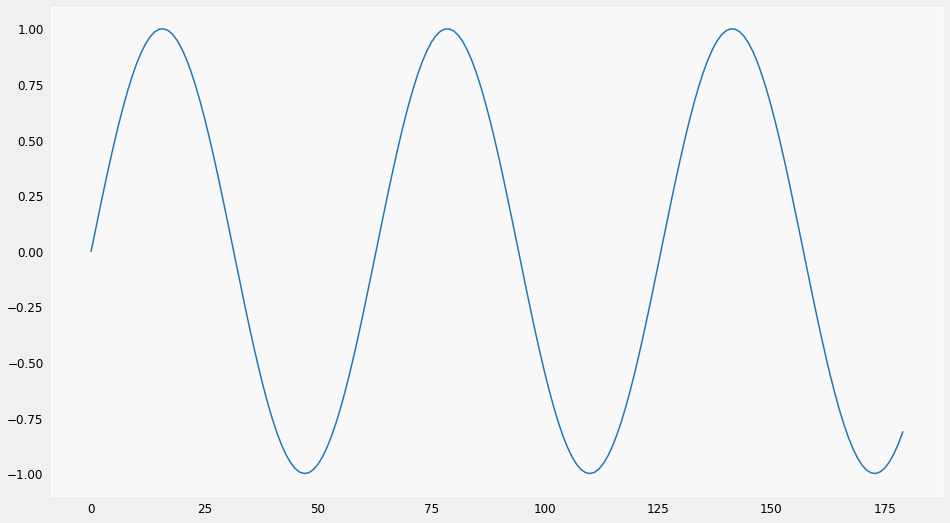

In [32]:
display_sinusoid()

Did it work ? If not, run the collapsed cell marked **RUN ME** and try again!


## Accelerators

Colaboratory offers free GPU and TPU (Tensor Processing Unit) accelerators.

You can choose your accelerator in *Runtime > Change runtime type*

The cell below is the standard boilerplate code that enables distributed training on GPUs or TPUs in Keras.


In [33]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy for hardware
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  strategy = tf.distribute.MirroredStrategy(gpus) # this works for 1 to multiple GPUs
  print('Running on ', len(gpus), ' GPU(s) ')
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

# How many accelerators do we have ?
print("Number of accelerators: ", strategy.num_replicas_in_sync)

# To use the selected distribution strategy:
# with strategy.scope:
#    # --- define your (Keras) model here ---
#
# For distributed computing, the batch size and learning rate need to be adjusted:
# global_batch_size = BATCH_SIZE * strategy.num_replicas_in_sync # num replcas is 8 on a single TPU or N when runing on N GPUs.
# learning_rate = LEARNING_RATE * strategy.num_replicas_in_sync

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Running on  1  GPU(s) 
Number of accelerators:  1


# Train A Neural Network (keras_01_mnist.ipynb)

### Parameters

In [34]:
#BATCH_SIZE = 128
BATCH_SIZE =64
EPOCHS = 10

# Stored on Google Cloud Storage
training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'

### Imports

In [35]:
import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
import numpy as np
import tensorflow as tf
# For visuals
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [36]:
#@title visualization utilities [RUN ME]
"""
This cell contains helper functions used for visualization
and downloads only. You can skip reading it. There is very
little useful Keras/Tensorflow code here.
"""

# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(16,9))
# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)
  
  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, validation_labels in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      break
    for training_digits, training_labels in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      break
    
  else:
    v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
    t_images, t_labels = batch_train_ds.make_one_shot_iterator().get_next()
    # Run once, get one batch. Session.run returns numpy results
    with tf.Session() as ses:
      (validation_digits, validation_labels,
       training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  fig = plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  plt.grid(b=None)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  display.display(fig)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 60000//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)
      
    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)

### tf.data.Dataset: parse files and prepare training and validation datasets
Please read the [best practices for building](https://www.tensorflow.org/guide/performance/datasets) input pipelines with tf.data.Dataset

In [37]:
AUTO = tf.data.experimental.AUTOTUNE

def read_label(tf_bytestring):
    label = tf.io.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label

# This is for decoding the image if compressed. Values of the images are casted to floats between 0 and 1. And the array is shaped as a flat array of 28*28
# This is because of the layers expects it to be like this later
# This function is used in load_dataset as a map function
def read_image(tf_bytestring):
    image = tf.io.decode_raw(tf_bytestring, tf.uint8)
    image = tf.cast(image, tf.float32)/256.0
    image = tf.reshape(image, [28*28])
    return image

# By the end, you have the images and labels together 
def load_dataset(image_file, label_file):
    # For the images
    imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
    imagedataset = imagedataset.map(read_image, num_parallel_calls=16)
    
    # For the labels
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    
    # Merging them together
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
    return dataset 
  
def get_training_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)

    # Though the dataset is loaded, can't use for training just yet

    # Essentially shuffling the training data
    dataset = dataset.cache()  # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # Mandatory for Keras for now

    # batches images based on the batch_size above
    dataset = dataset.batch(batch_size, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
    # Gets data while the other data is being prepared
    dataset = dataset.prefetch(AUTO)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return dataset
  
def get_validation_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache() # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

#Essentially loading the data for MNIST

# instantiate the datasets
training_dataset = get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file, validation_labels_file)

# For TPU, we will need a function that returns the dataset
training_input_fn = lambda: get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_input_fn = lambda: get_validation_dataset(validation_images_file, validation_labels_file)

### Let's have a look at the data

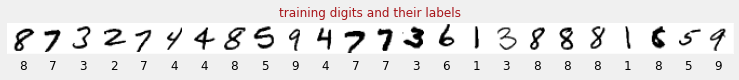

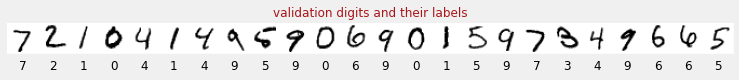

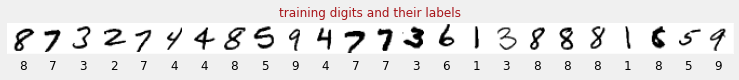

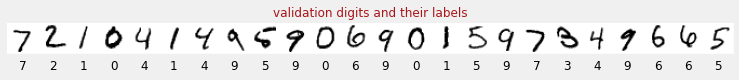

In [38]:
N = 24
(training_digits, training_labels,
 validation_digits, validation_labels) = dataset_to_numpy_util(training_dataset, validation_dataset, N)
display_digits(training_digits, training_labels, training_labels, "training digits and their labels", N)
display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "validation digits and their labels", N)
font_digits, font_labels = create_digits_from_local_fonts(N)

### Keras model
If you are not sure what cross-entropy, dropout, softmax or batch-normalization mean, head here for a crash-course: [Tensorflow and deep learning without a PhD](https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd/#featured-code-sample)

In [39]:
# Model will be simple and sequential
# Single dense layer for now, with 10 classes (0 - 9)
# model = tf.keras.Sequential(
#   [
#       tf.keras.layers.Input(shape=(28*28,)),
#       tf.keras.layers.Dense(10, activation='softmax')
#   ])

# Adding layers:

# model = tf.keras.Sequential(
#   [
#       tf.keras.layers.Input(shape=(28*28,)),
#       tf.keras.layers.Dense(200, activation='sigmoid'),
#       tf.keras.layers.Dense(60, activation='sigmoid'),
#       tf.keras.layers.Dense(10, activation='softmax')
#   ])

# The results with this new model results lowers accuracy unfortunately...

# Using Relu instead of sigmoid. Sigmoid squashes the values between 0 and 1, reducing the accuracy. Use relu instead

# model = tf.keras.Sequential(
#   [
#       tf.keras.layers.Input(shape=(28*28,)),
#       tf.keras.layers.Dense(200, activation='relu'),
#       tf.keras.layers.Dense(60, activation='relu'),
#       tf.keras.layers.Dense(10, activation='softmax')
#   ])

# Adding 4 layers

# model = tf.keras.Sequential(
#   [
#       tf.keras.layers.Input(shape=(28*28,)),
#       tf.keras.layers.Dense(200, activation='relu'),
#       tf.keras.layers.Dense(100, activation='relu'),
#       tf.keras.layers.Dense(60, activation='relu'),
#       tf.keras.layers.Dense(10, activation='softmax')
#   ])

# Drop out
# model = tf.keras.Sequential(
#   [
#       tf.keras.layers.Input(shape=(28*28,)),
#       tf.keras.layers.Dense(200, activation='relu'),
#       tf.keras.layers.Dropout(0.25),
#       tf.keras.layers.Dense(100, activation='relu'),
#       tf.keras.layers.Dropout(0.25),
#       tf.keras.layers.Dense(60, activation='relu'),
#       tf.keras.layers.Dropout(0.25),
#       tf.keras.layers.Dense(10, activation='softmax')
#   ])

#convolutional networks
model = tf.keras.Sequential(
  [
      tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),
      tf.keras.layers.Conv2D(kernel_size=3, filters=12, padding='same', activation='relu'),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
   
      tf.keras.layers.Conv2D(kernel_size=6, filters=24, padding='same', activation='relu', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
   
      tf.keras.layers.Flatten(),
      
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
   
      tf.keras.layers.Dropout(0.3), 
      tf.keras.layers.Dense(10, activation='softmax')
  ])



# How does one know how to setup the layers? Trial and error?

# remember training is done by following the gradient. With sigmoid, the gradient can be very small resulting in slower training.
# With relu, training can continue at a good pace.

# Stuff we learned before
# using stochastic gradient descent
# For the loss function, using cross entropy
# model.compile(optimizer='sgd',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# Changing optimizer to adam to avoid saddle points in gradient descent
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# no need to worry about initializing weights, keras already does a good job using glorot_uniform 
# Also no need to worry about cross-entropy being zero, the softfunction applied outputs exponential values. Keras takes care of this in a careful way so it doesn't crash

# Now we are above 97% woot but apparently we need to do better

# We will change the learning rate from .001 to .01 so it learns faster
# model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# Because the graph is noisy, that means we are learning too fast.

# Changing it back but there is another way:

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
#plot_training = PlotTraining(sample_rate=10, zoom=1)

# plot_training = PlotTraining(sample_rate=10, zoom=5)
plot_training = PlotTraining(sample_rate=10, zoom=10)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 12)        120       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 12)        36        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 12)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 24)        10392     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 24)        72        
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 24)       

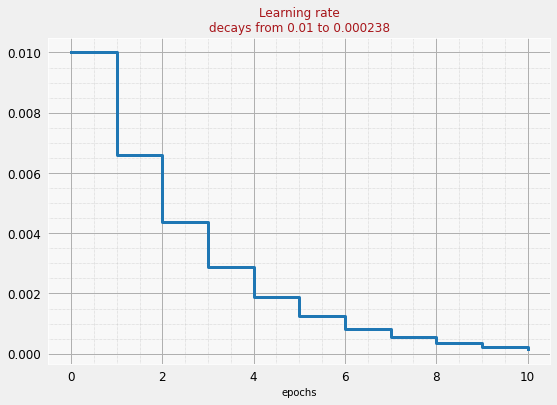

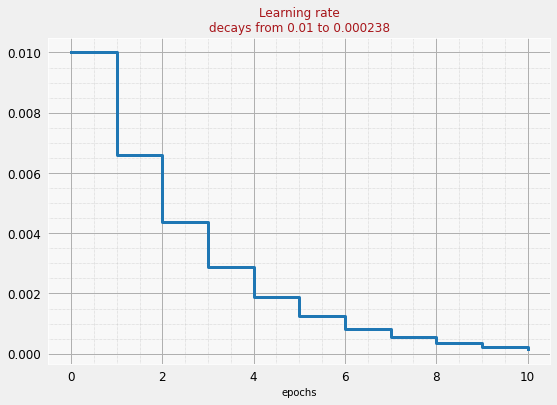

In [40]:
# This will allow it to learn fast and slow down exponentially
# lr decay function
def lr_decay(epoch):
  return 0.01 * math.pow(0.66, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
plot_learning_rate(lr_decay, EPOCHS)

### Train and validate the model

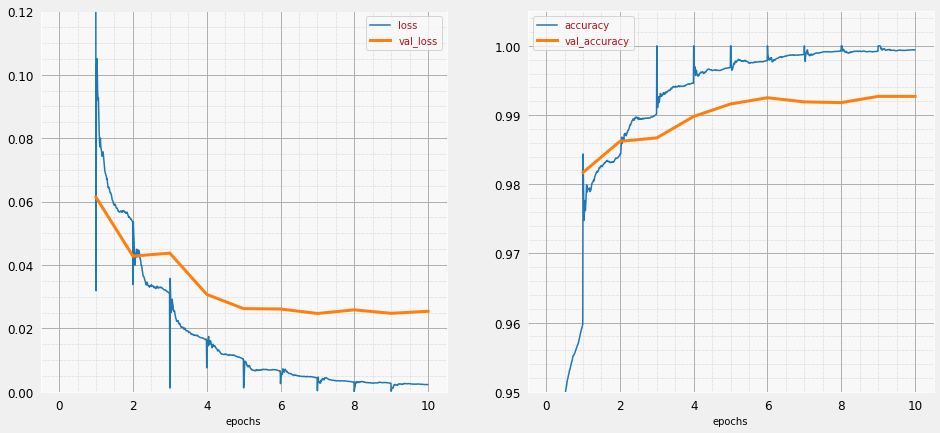

In [41]:
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

# Essentially training with training and validation data. By default, validation is done after each iteration (epoch)
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training, lr_decay_callback])

### Visualize predictions

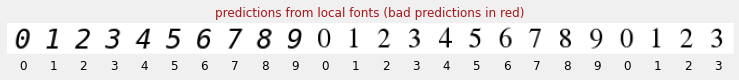

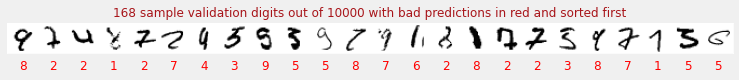

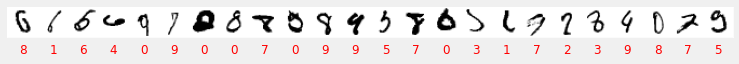

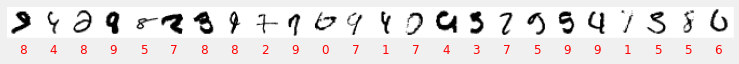

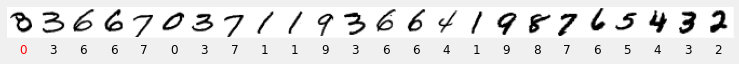

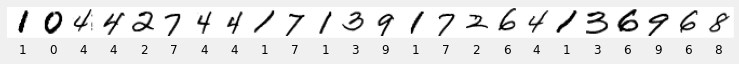

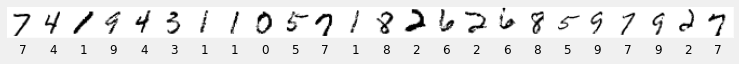

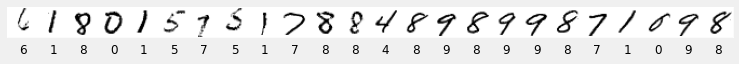

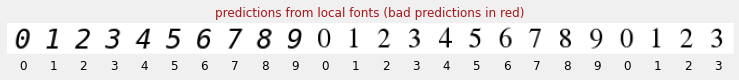

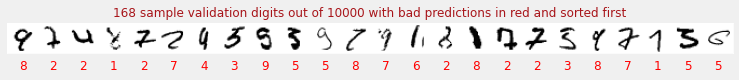

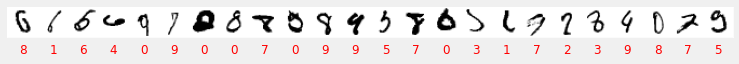

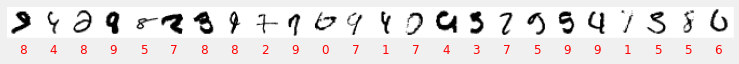

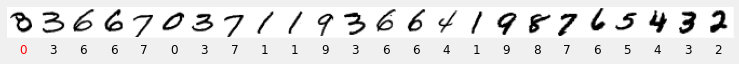

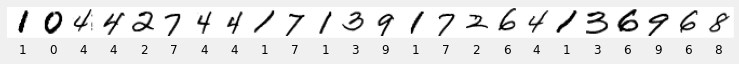

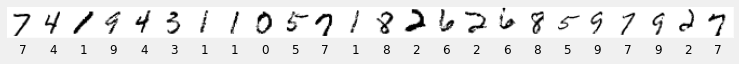

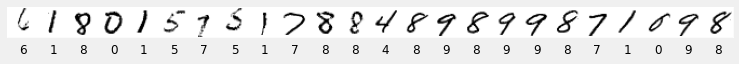

In [42]:
# recognize digits from local fonts
probabilities = model.predict(font_digits, steps=1)
# Remember, the predictions give a probability for each class, the max is the one we want. That is the label for the image that it determined
predicted_labels = np.argmax(probabilities, axis=1)

display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

# recognize validation digits
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)

#Notes

* Tensors are the multidimensional matrices that hold data for an image.

* The shape is essentially the dimensions of the matrices.

* A neural network is made up of multiple layers of neurons.

* Image classification has dense (or **Convolutional**) layers

* Activated by a **relu** activation function

* The last layer uses as many neurons as classes. This is activated with a **softmax**. 

* Cross-entropy is a common loss function. This compares the prediction of the model to the actual labels of the object.

* One way to minimize loss is to use a optimizer with momentum. One is known as Adam and trains on batches to reduce loss.

Lot's of vocabulary but nothing too difficult :) 

## Matrix Multiplication

This is how I understood this. Each column in the wieght matrix represents each neuron class (from 0 to 9). The row of an image is then multiplied with each. Weight summation of each is compared, the highest one will help classify which class it belongs to, in our example which number is it. 

For each neuron there is a bias that is added to the matrix generated from multiplying the image matrix with the weight matrix. This is called **broadcasting**. The reason for this is, if the vector for the bias is not the same dimensions and cannot be added, you can replicate the value appropriately to add the bias for the respective weight.


A softmax function is applied to this.

## Keras

Remember Keras is high level.

## Different kinds of activation functions

**relu** activation is used for all but the last one.

The last layer used the softmax function.

Side question, what is being passed from one neuron to the next and what is the new neuron computing with respect to the information it received from the previous neuron?

Anyways Relu is more prominent now, **sigmoid** use to be better. But for convergance, Relu is better.

## Softmax for activation
In this example we we have 10 neurons, one for each class (0 - 9). Before the activation function is called, the output is called **logits**.

Exponential is steeply increasing, which would increase the difference in the neurons outputs. Once you normalize the vector, one will dominate and will be closer to 1. This will be the class for the image passed in. In addition the relative order is still kept, which is why is why it contains the soft portion.

## Cross Entropy Loss

This is straight forward to be honest.

## Gradient Descent

Training is essentially trying to adjust the weights and bias to reduce the cross-entropy loss function.

Essentially what you are doing here is you are plotting the results of the model with the current weights and seeing the cross-entropy values. We want cross-entropy to be lower, so we adjust the weights and bias by a fraction and do the same with the next batch of image/train data.

The goal is to eventually hit a low cross-entropy value but we can't really ensure that.

Side question: in the graph, how is the cross-entropy values above 1 and below 0? Shouldn't they be between 0 and 1?

Learning rate is essentially going at an adequate pace. If you were on a mountain, you wouldn't jump straight down. 

## Min batching and momentum

You can compute this on a single image basis, but doing it on a batch of images shows the constrains by several many images and can converge to a better solution. Not sure how that works.

Since we are working with batches, the matrices can get bigger. So it is good to use the GPU which can handle this kind of stuff.

Gradient can be zero but not necessarily max/min. Can be a saddle point. By adding momentum, you can solve this.

Side question: how do you make the gradient descent graph. Very confused by this.

## Convolutional Networks

I'll be really honest I don't understand this portion... The diagram doesn't make sense.

